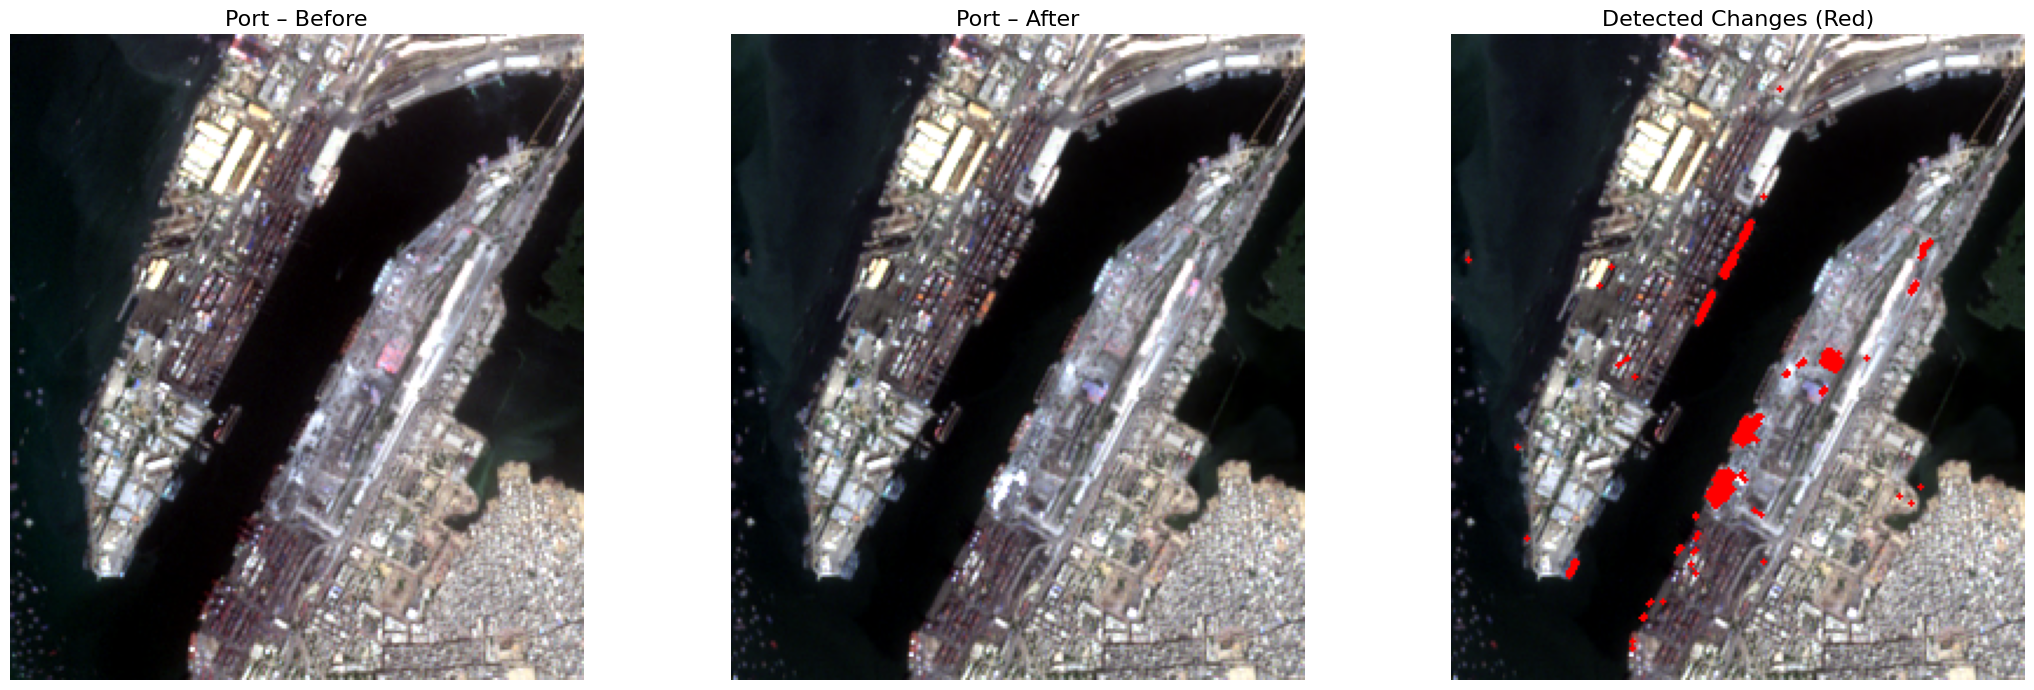

Saved binary change mask TIFF: E:\EO-SAR_change_detection\output\sen-2\sentinel2_change_mask.tif
Saved changes as GeoJSON: E:\EO-SAR_change_detection\output\sen-2\sentinel2_changes.geojson


In [ ]:
import os
import rasterio
import numpy as np
from sklearn.decomposition import PCA
from skimage.measure import label, regionprops
from scipy.ndimage import binary_opening, binary_closing
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes

# -------------------------
# Parameters (PLACEHOLDERS)
# -------------------------
pre_file  = r"E:\EO-SAR_change_detection\Data\Processed\Sentinel2\pre\S2_merged_20251009_CLIP_pre.tif"
post_file = r"E:\EO-SAR_change_detection\Data\Processed\Sentinel2\post\S2_merged_20251012_CLIP_post.tif"
OUT_FOLDER = r"E:\EO-SAR_change_detection\output"

os.makedirs(OUT_FOLDER, exist_ok=True)

MIN_SHIP_AREA = 3
MAX_SHIP_AREA = 300
EPS = 1e-9

# -------------------------
# Helper functions
# -------------------------
def read_stack(path, bands):
    with rasterio.open(path) as src:
        arr = src.read(bands).astype(np.float32)
        profile = src.profile
        return arr, profile

def scale_rgb(arr, clip_min=0, clip_max=8000):
    arr = np.clip(arr, clip_min, clip_max)
    arr = arr / arr.max()
    return np.transpose(arr, (1,2,0))

def save_mask_georef(path, mask, profile):
    """Save a georeferenced binary mask."""
    profile_out = profile.copy()
    profile_out.update(dtype=rasterio.uint8, count=1, compress='lzw')
    with rasterio.open(path, 'w', **profile_out) as dst:
        dst.write(mask.astype(np.uint8), 1)

def mask_to_geojson_georef(mask, profile, out_path, min_area=1):
    """Convert a binary mask to a georeferenced GeoJSON."""
    shapes_gen = shapes(mask.astype(np.uint8), mask=mask.astype(bool), transform=profile['transform'])
    polygons = [shape(geom) for geom, val in shapes_gen if val == 1]

    # Filter tiny polygons
    pixel_area = abs(profile['transform'][0] * profile['transform'][4])
    polygons = [poly for poly in polygons if poly.area >= min_area * pixel_area]

    if len(polygons) == 0:
        print("No changes detected for GeoJSON.")
        return

    gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=profile['crs'])
    gdf.to_file(out_path, driver="GeoJSON")
    print("Saved georeferenced GeoJSON:", out_path)

# -------------------------
# Load Sentinel-2 bands
# -------------------------
pre, profile  = read_stack(pre_file, [1,2,3,4])  # B4, B3, B2, B8
post, _       = read_stack(post_file, [1,2,3,4])

H, W = pre.shape[1:]

# -------------------------
# PCA-based change detection
# -------------------------
diff = post - pre
diff_flat = diff.reshape(4, -1).T

pca = PCA(n_components=4)
pc = pca.fit_transform(diff_flat)
pc1 = pc[:,0].reshape(H, W)
pc1_abs = np.abs(pc1)

thresh = np.percentile(pc1_abs, 95)
change_mask = pc1_abs > thresh

change_mask = binary_opening(change_mask, iterations=1)
change_mask = binary_closing(change_mask, iterations=2)

# Filter ship-like objects
labeled = label(change_mask)
final_mask = np.zeros_like(change_mask, dtype=np.uint8)

for region in regionprops(labeled):
    if MIN_SHIP_AREA <= region.area <= MAX_SHIP_AREA:
        final_mask[labeled == region.label] = 1

# -------------------------
# Prepare RGB images for plotting
# -------------------------
pre_rgb  = scale_rgb(pre[:3])
post_rgb = scale_rgb(post[:3])

# Overlay changes in red
overlay = post_rgb.copy()
overlay[:,:,0] = np.clip(overlay[:,:,0] + final_mask, 0, 1)
overlay[:,:,1] *= (1 - final_mask)
overlay[:,:,2] *= (1 - final_mask)

# -------------------------
# Visualization
# -------------------------
fig, ax = plt.subplots(1, 3, figsize=(22, 7))
ax[0].imshow(pre_rgb); ax[0].set_title("Before", fontsize=16); ax[0].axis("off")
ax[1].imshow(post_rgb); ax[1].set_title("After", fontsize=16); ax[1].axis("off")
ax[2].imshow(overlay); ax[2].set_title("Detected Changes (Red)", fontsize=16); ax[2].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(OUT_FOLDER, "change_detection_result.png"), dpi=200)
plt.show()

# -------------------------
# Save mask TIFF (georeferenced)
# -------------------------
mask_path = os.path.join(OUT_FOLDER, "change_mask.tif")
save_mask_georef(mask_path, final_mask, profile)
print("Saved georeferenced binary mask TIFF:", mask_path)

# -------------------------
# Save GeoJSON (georeferenced)
# -------------------------
geojson_path = os.path.join(OUT_FOLDER, "change_polygons.geojson")
mask_to_geojson_georef(final_mask, profile, geojson_path)
